<a href="https://colab.research.google.com/github/cmwema/djangoMLAPI/blob/main/loanApprovalPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn import svm
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
import warnings
from collections import Counter
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
from keras import Sequential
from keras.layers import Dense

# Load data
- In this case, the dataset is uploaded from local machine.

In [14]:
from google.colab import files


uploaded = files.upload()

Saving bankloan.csv to bankloan (1).csv


In [15]:
import io
for filename, content in uploaded.items():
    df = pd.read_csv(io.BytesIO(content))

In [16]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0.0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1.0,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0.0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0.0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0.0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


# Preprocessing

In [18]:
df = df.dropna()
df.isna().any()
df = df.drop('Loan_ID', axis=1)
df['LoanAmount'] = (df['LoanAmount']*1000).astype(int)
Counter(df['Loan_Status'])

Counter({'N': 148, 'Y': 332})

In [19]:
# % of yes
Counter(df['Loan_Status'])['Y']/df['Loan_Status'].size

0.6916666666666667

In [20]:
pre_y = df['Loan_Status']
pre_x = df.drop('Loan_Status', axis=1)
dm_x = pd.get_dummies(pre_x)
dm_y = pre_y.map(dict(Y=1, N=0))

In [21]:
pre_x.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
1,Male,Yes,1.0,Graduate,No,4583,1508.0,128000,360.0,1.0,Rural
2,Male,Yes,0.0,Graduate,Yes,3000,0.0,66000,360.0,1.0,Urban
3,Male,Yes,0.0,Not Graduate,No,2583,2358.0,120000,360.0,1.0,Urban
4,Male,No,0.0,Graduate,No,6000,0.0,141000,360.0,1.0,Urban
5,Male,Yes,2.0,Graduate,Yes,5417,4196.0,267000,360.0,1.0,Urban


In [23]:
dm_x.head()

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Female,Gender_Male,Married_No,Married_Yes,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
1,1.0,4583,1508.0,128000,360.0,1.0,0,1,0,1,1,0,1,0,1,0,0
2,0.0,3000,0.0,66000,360.0,1.0,0,1,0,1,1,0,0,1,0,0,1
3,0.0,2583,2358.0,120000,360.0,1.0,0,1,0,1,0,1,1,0,0,0,1
4,0.0,6000,0.0,141000,360.0,1.0,0,1,1,0,1,0,1,0,0,0,1
5,2.0,5417,4196.0,267000,360.0,1.0,0,1,0,1,1,0,0,1,0,0,1


In [24]:
pre_y.head()

1    N
2    Y
3    Y
4    Y
5    Y
Name: Loan_Status, dtype: object

In [25]:
dm_y.head()

1    0
2    1
3    1
4    1
5    1
Name: Loan_Status, dtype: int64

In [35]:
smote = SMOTE(sampling_strategy='minority')
x1, y = smote.fit_resample(dm_x, dm_y)
sc = MinMaxScaler()
x = sc.fit_transform(x1)

In [32]:
print(f'Resampled dataset shape {Counter(y)}')

Resampled dataset shape Counter({0: 332, 1: 332})


In [36]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, shuffle=True)

array([[0.        , 0.03030303, 0.05647664, ..., 0.        , 1.        ,
        0.        ],
       [0.07207912, 0.07768707, 0.1167593 , ..., 1.        , 0.        ,
        0.        ],
       [0.18861329, 0.0522449 , 0.07700124, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.11048856, 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.0462214 , 0.07887815, ..., 0.        , 1.        ,
        0.        ],
       [0.66666667, 0.03915894, 0.10343707, ..., 0.        , 0.        ,
        1.        ]])

# The Classifier Model
- Sequential Neural Network Model is used.

In [66]:
# Define the classifier model
classifier = Sequential()

# Add layers to the model
classifier.add(Dense(200, activation='relu', kernel_initializer='random_normal', input_shape=(X_train.shape[1],)))
classifier.add(Dense(800, activation='relu', kernel_initializer='random_normal'))
classifier.add(Dense(50, activation='relu', kernel_initializer='random_normal'))
classifier.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))

# Compile the model
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
classifier.fit(X_train, y_train, batch_size=10, epochs=100)

# Evaluate the model on the test data
eval_model = classifier.evaluate(X_test, y_test)
eval_model

Epoch 1/100
54/54 [==============================] - 1s 5ms/step - loss: 0.6578 - accuracy: 0.6365
Epoch 2/100
54/54 [==============================] - 0s 4ms/step - loss: 0.4438 - accuracy: 0.8041
Epoch 3/100
54/54 [==============================] - 0s 4ms/step - loss: 0.3990 - accuracy: 0.8286
Epoch 4/100
54/54 [==============================] - 0s 4ms/step - loss: 0.3898 - accuracy: 0.8267
Epoch 5/100
54/54 [==============================] - 0s 5ms/step - loss: 0.3693 - accuracy: 0.8493
Epoch 6/100
54/54 [==============================] - 0s 4ms/step - loss: 0.3578 - accuracy: 0.8493
Epoch 7/100
54/54 [==============================] - 0s 4ms/step - loss: 0.3506 - accuracy: 0.8569
Epoch 8/100
54/54 [==============================] - 0s 5ms/step - loss: 0.3415 - accuracy: 0.8512
Epoch 9/100
54/54 [==============================] - 0s 5ms/step - loss: 0.3501 - accuracy: 0.8531
Epoch 10/100
54/54 [==============================] - 0s 4ms/step - loss: 0.3448 - accuracy: 0.8550
Epoch 11/

[1.3097690343856812, 0.8496240377426147]

# Testing the model

In [67]:
y_pred = classifier.predict(X_test)
y_pred = (y_pred > 0.5) # over 0.5 loan is approved otherwise it is rejected

5/5 [==============================] - 0s 4ms/step


# Confusion Matrix

[Text(0, 0.5, 'No'), Text(0, 1.5, 'Yes')]

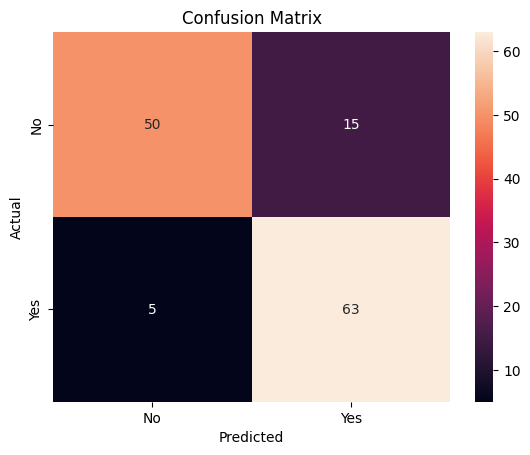

In [68]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel("Actual")
ax.set_title("Confusion Matrix")
ax.xaxis.set_ticklabels(["No", "Yes"])
ax.yaxis.set_ticklabels(["No", "Yes"])